In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

# Assignment
Familiarity with several pricing models and how to apply them to a portfolio. Now calculate the VWAP, Sharpe and Alpha for your portfolio from the start of the semester  to the date of you calculations. Your calculation results and the VaR calculations that you performed last week are the main content of the Portfolio Review presentation that is next week's subject and assignment. 

-- Remember Presentation is Important


<b> Sharpe Ratio </b>

Sharpe ratio is a measure for calculating risk-adjusted return. It is the ratio of the excess expected return of investment (over risk-free rate) per unit of volatility or standard deviation. 

# Variables

In [2]:
period = '5y'

# Load Data

## Load Variables

In [3]:
#var_lst = ['^SPX']
#var_lst = ['^TNX']
var_lst = ['TNX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
rf_df = data.pct_change()
rf_rate = rf_df.mean()
rf_rate

[*********************100%%**********************]  1 of 1 completed


-0.016533451391655823

## Load Portfolio

folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w6/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })

In [4]:
folio_df = pd.read_csv('./data/DATA618_Portfolio_Rebalance_v2.csv', 
                 parse_dates=['Purchase_Date'],
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float',
                 })

folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.000000","1,000.000000",0.011570
1,ARKK,ARK Innovation ETF,Economically Sensitive,U.S. Equities,"26,476.000000","1,000.000000",0.011570
2,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.000000",500.000000,0.005785
3,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.000000",750.000000,0.008677
4,C_A_S_H,Cash,Cash,Cash,"3,182,856.000000","4,183.000000",0.048396
5,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.000000","2,250.000000",0.026032
6,EXAS,Exact Sciences Corp,Economically Sensitive,U.S. Equities,"7,660.000000",500.000000,0.005785
7,FREL,Fidelity MSCI Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"115,479.000000","2,800.000000",0.032395
8,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,"89,079.000000","4,000.000000",0.046279
9,GARIX,Gotham Absolute Return Institutional,Economically Sensitive,Long/Short Equities,"25,278.000000",500.000000,0.005785


In [5]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,183.000000"
Economically Sensitive,"53,250.000000"
Interest Rate Sensitive,"29,000.000000"


In [6]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

86433000.0

# Portfolio

## Load Pricing Time Series

In [7]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
print('return_df #:', len(return_df.columns))

ticker #: 40
price #: 40
[*********************100%%**********************]  40 of 40 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No data found, symbol may be delisted')



price_df #: (1258, 40)
return_df #: 40


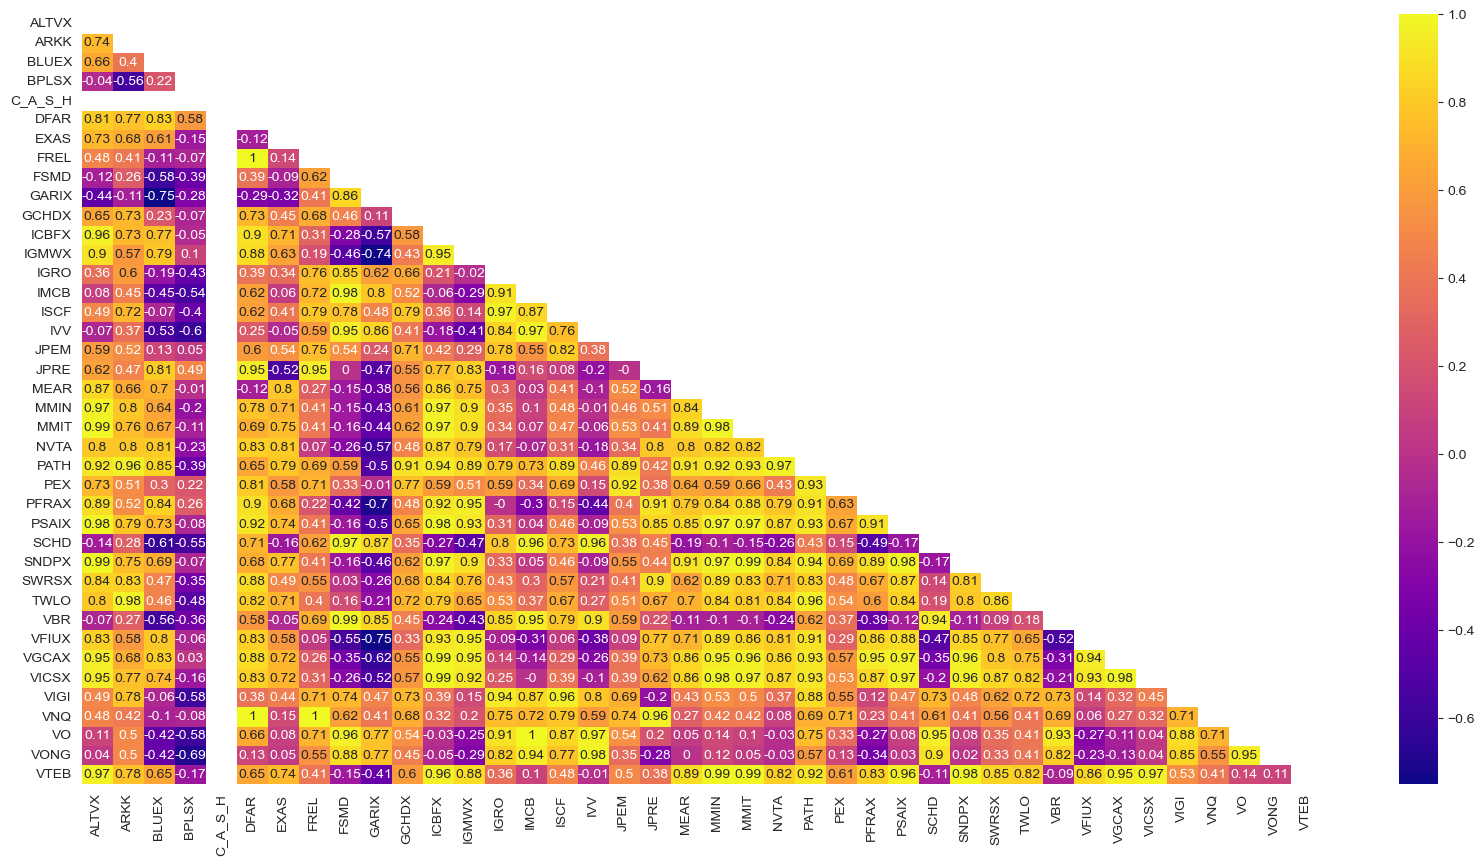

In [8]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

## Portfolio Returns

In [9]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

port_ret_weighted #: (1258, 40)
return_df #: (1258, 41)


In [10]:
tickers='^DJA'

DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_df['Benchmark']= DJA['Close']
return_df['Benchmark']= return_df['Benchmark'].pct_change(1) #.dropna()

print('return_df #:', return_df.shape)

[*********************100%%**********************]  1 of 1 completed
return_df #: (1258, 42)


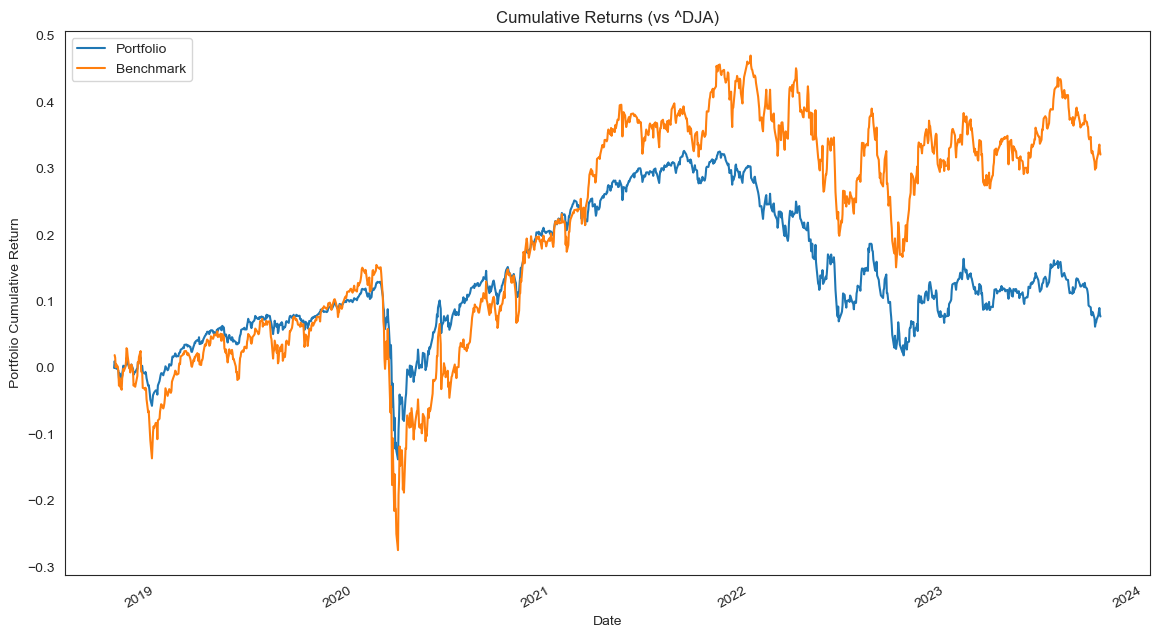

In [11]:
cum_ret_port = ((1 + return_df[['Portfolio','Benchmark']]).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(14,8),title='Cumulative Returns (vs ^DJA)')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [12]:
port_bench = pd.concat([return_df['Portfolio' ],return_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.000000,0.914138
Benchmark,0.914138,1.000000


## Sharpe Ratio

In [13]:
return_df['RF Rate']= rf_rate

sharpe_ratio=((return_df['Portfolio'].mean() - return_df['RF Rate'].mean()))/return_df['Portfolio' ].std()
sh = round(sharpe_ratio,4)
print(f"Sharpe Ratio: {sh:.7f} (50% {sh*0.5:.7f})")

avg = return_df['Portfolio'].mean() * 100
print(f"Portfolio Return Mean: {avg:.7f}")

std = return_df['Portfolio' ].std()
print(f"Portfolio Return Standard Deviation: {std:.7f}")

Sharpe Ratio: 2.1296000 (50% 1.0648000)
Portfolio Return Mean: 0.0089940
Portfolio Return Standard Deviation: 0.0078061


# Economically Sensitive

## Load Pricing Time Series

In [14]:
# ticker symbols
ticker_lst = list(folio_econ_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_econ_df['port_percent'].values)
print('price #:', len(weight_lst))

#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
price_econ_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

#From the closing prices, calculate periodic returns
return_econ_df = price_econ_df.pct_change()
return_econ_df = return_econ_df[1:]
print('return_df #:', return_econ_df.shape)

ticker #: 25
price #: 25
[*********************100%%**********************]  25 of 25 completed
return_df #: (1257, 25)


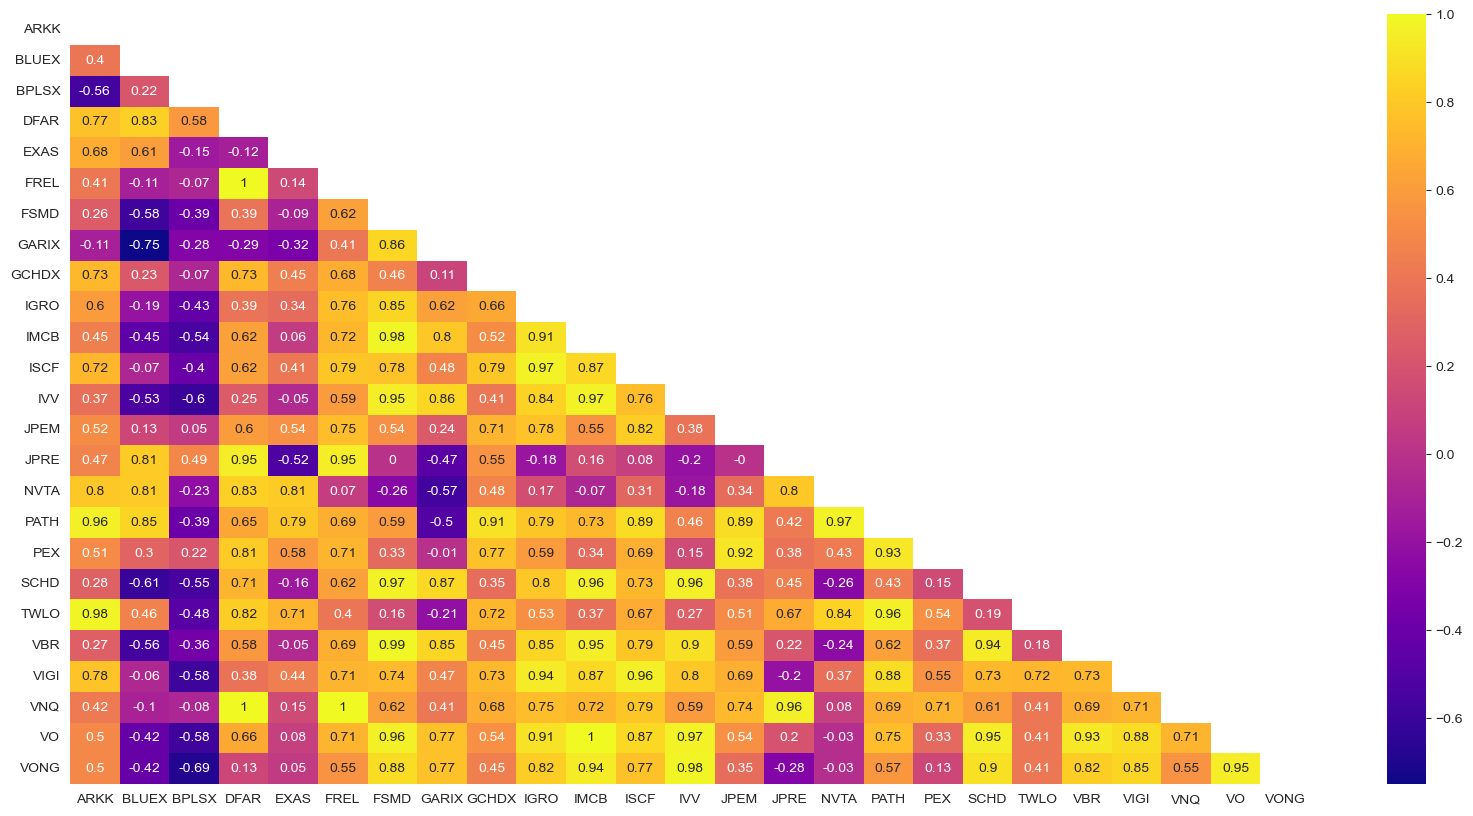

In [15]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_econ_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_econ_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

## Portfolio Returns

In [16]:
port_ret_weighted= return_econ_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

#return_econ_df['Portfolio'] = port_ret_weighted.sum(axis=1).dropna()
return_econ_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_econ_df #:', return_econ_df.shape)

port_ret_weighted #: (1257, 25)
return_econ_df #: (1257, 26)


In [17]:
tickers='^DJA'
#tickers = 'FHNFX'
DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_econ_df['Benchmark']= DJA['Close']
return_econ_df['Benchmark']= return_econ_df['Benchmark'].pct_change(1) #.dropna()
#return_df= return_df.dropna()
print('return_econ_df #:', return_econ_df.shape)

[*********************100%%**********************]  1 of 1 completed
return_econ_df #: (1257, 27)


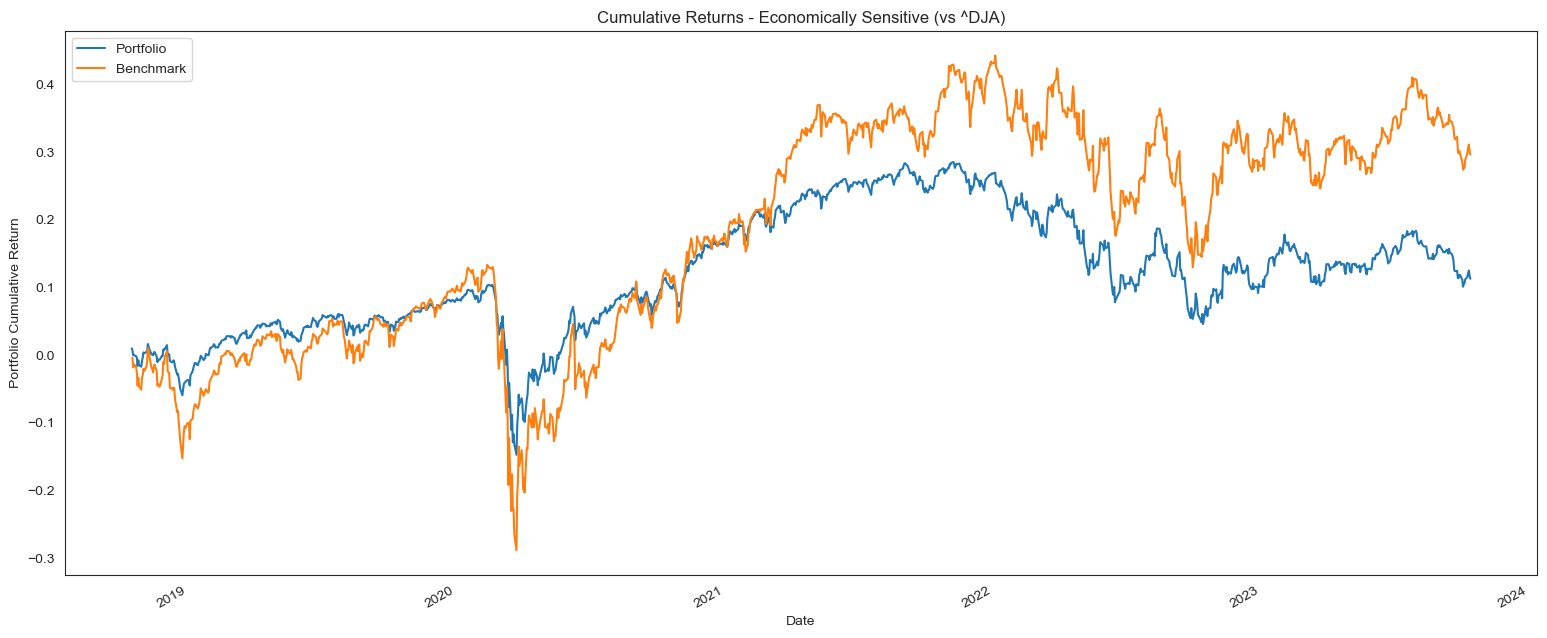

In [18]:
cum_ret_port = ((1 + return_econ_df[['Portfolio','Benchmark']]).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(19,8),title='Cumulative Returns - Economically Sensitive (vs ^DJA)')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [19]:
port_bench = pd.concat([return_econ_df['Portfolio' ],return_econ_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.000000,0.928021
Benchmark,0.928021,1.000000


## Sharpe Ratio

In [20]:
return_econ_df['RF Rate']= rf_rate

sharpe_ratio=((return_econ_df['Portfolio'].mean() - return_econ_df['RF Rate'].mean()))/return_econ_df['Portfolio' ].std()
sh = round(sharpe_ratio,4)
print(f"Sharpe Ratio: {sh:.7f} (50% {sh*0.5:.7f})")

avg = return_econ_df['Portfolio'].mean() * 100
print(f"Portfolio Return Mean: {avg:.7f}")

std = return_econ_df['Portfolio' ].std()
print(f"Portfolio Return Standard Deviation: {std:.7f}")

Sharpe Ratio: 2.1922000 (50% 1.0961000)
Portfolio Return Mean: 0.0113997
Portfolio Return Standard Deviation: 0.0075939


# Interest Rate Sensitive

## Load Pricing Time Series

In [21]:
# ticker symbols
ticker_lst = list(folio_int_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_int_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
price_int_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

#price_df['C_A_S_H'] = 1
#print('price_df #:', len(price_df.columns))

#From the closing prices, calculate periodic returns
return_int_df = price_int_df.pct_change()
print('return_df #:', len(return_int_df.columns))

ticker #: 14
price #: 14
[*********************100%%**********************]  14 of 14 completed
return_df #: 14


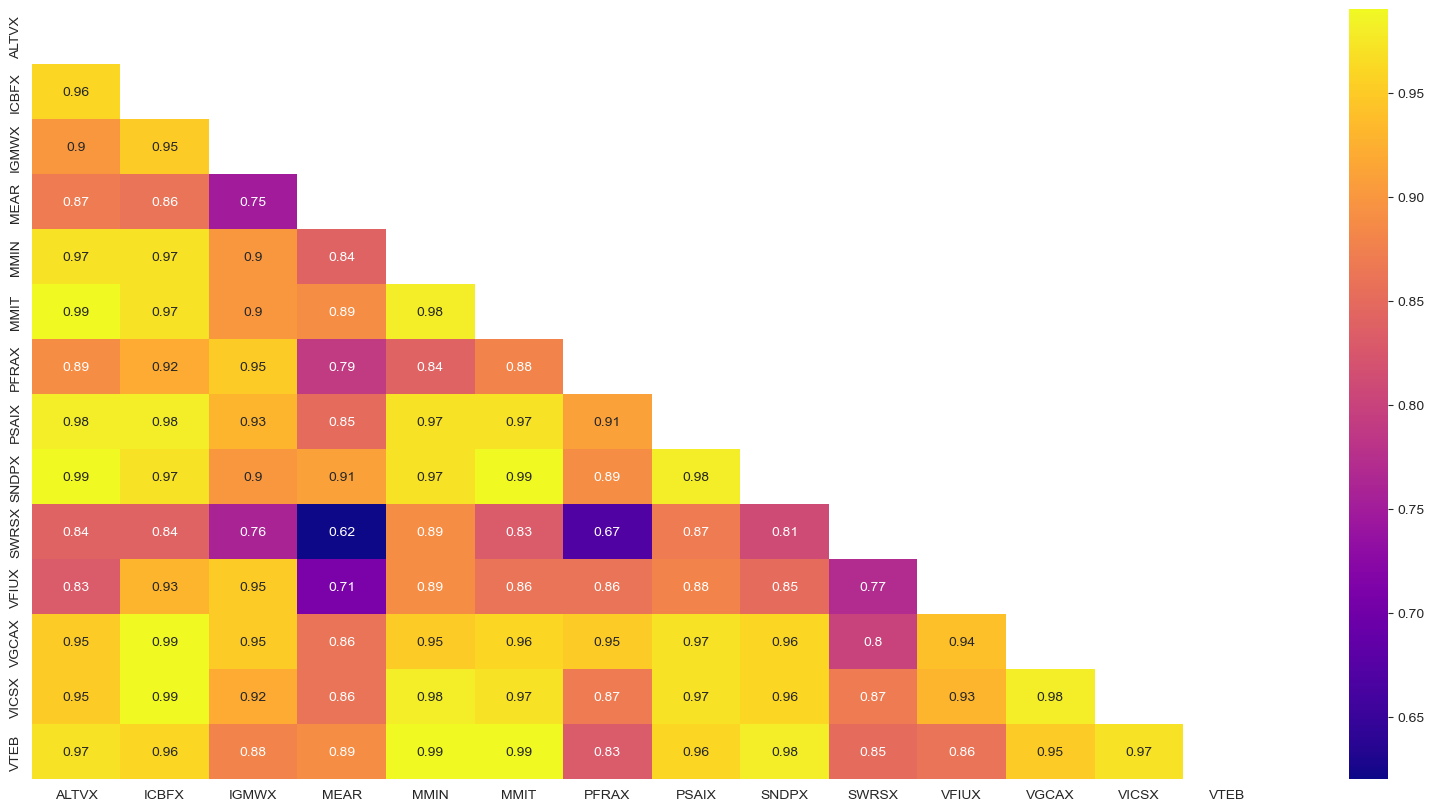

In [22]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_int_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_int_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

## Portfolio Returns

In [23]:
port_ret_weighted= return_int_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', len(port_ret_weighted))

return_int_df['Portfolio']= port_ret_weighted.sum(axis=1).dropna()
print('return_int_df #:', return_int_df.columns.shape)

port_ret_weighted #: 1258
return_int_df #: (15,)


In [24]:
#tickers='^SP500BDT'
tickers = 'FHNFX'
BOND = pdr.get_data_yahoo(tickers=tickers, period=period)
return_int_df['Benchmark']= BOND['Close']
return_int_df['Benchmark']= return_int_df['Benchmark'].pct_change(1)

print('return_int_df #:', return_int_df.shape)

[*********************100%%**********************]  1 of 1 completed
return_int_df #: (1258, 16)


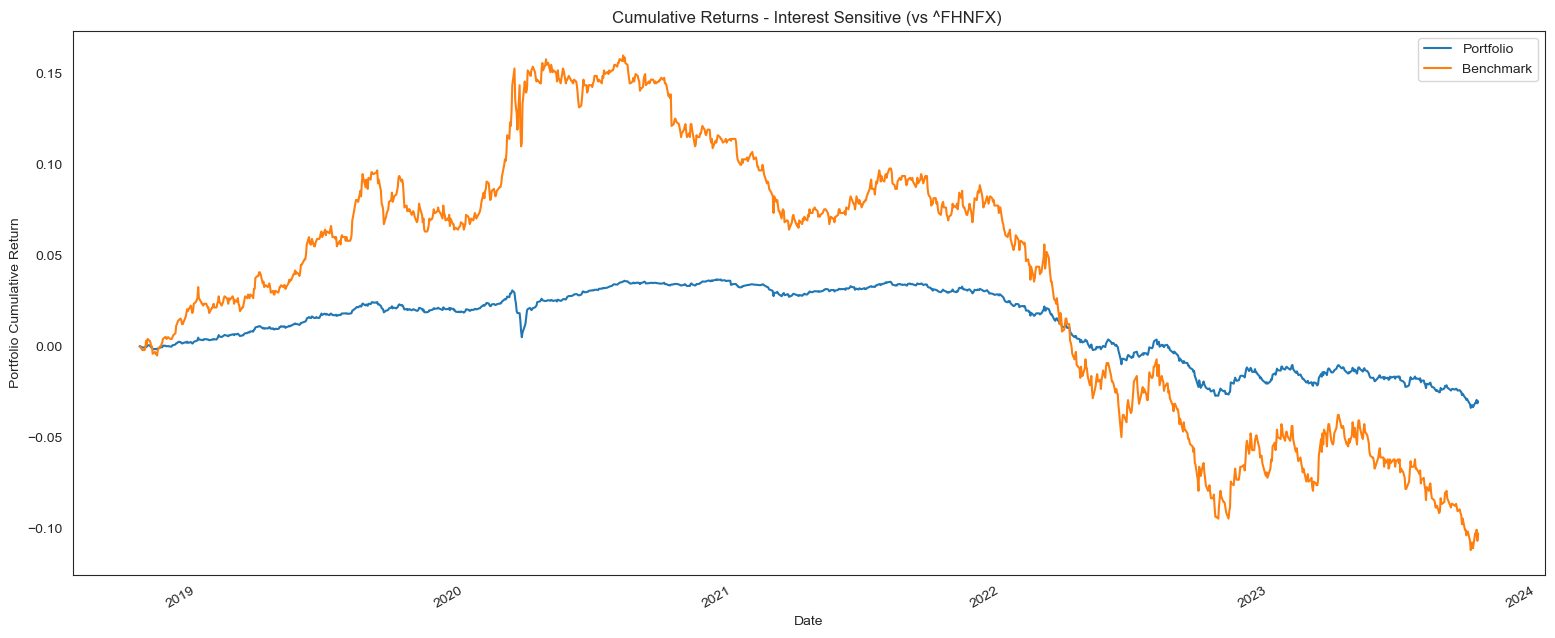

In [25]:
cum_ret_port = ((1 + return_int_df[['Portfolio','Benchmark']]).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(19,8),title='Cumulative Returns - Interest Sensitive (vs ^FHNFX) ')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [26]:
port_bench = pd.concat([return_int_df['Portfolio' ],return_int_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.000000,0.841763
Benchmark,0.841763,1.000000


## Sharpe Ratio

In [27]:
return_int_df['RF Rate']= rf_rate

sharpe_ratio=((return_int_df['Portfolio'].mean() - return_int_df['RF Rate'].mean()))/return_int_df['Portfolio' ].std()
sh = round(sharpe_ratio,4)
print(f"Sharpe Ratio: {sh:.7f} (50% {sh*0.5:.7f})")

avg = return_int_df['Portfolio'].mean() * 100
print(f"Portfolio Return Mean: {avg:.7f}")

std = return_int_df['Portfolio' ].std()
print(f"Portfolio Return Standard Deviation: {std:.7f}")

Sharpe Ratio: 18.6920000 (50% 9.3460000)
Portfolio Return Mean: -0.0023966
Portfolio Return Standard Deviation: 0.0008832
